In [9]:
import numpy as np
import emcee
from matplotlib import pyplot as plt
import corner
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [153]:
mean = 3
sd = 2
data_size = 100
ndim = 2
nwalkers = 10
gaussian_data = np.random.normal(mean, sd, size=data_size)
pseudo_log_prob_per = lambda d, p: 0
bound_prob = lambda p: (np.mean(gaussian_data) - p[0]) ** 2 / (2 * p[1] ** 2)

def log_prob(param):
    # yay for exponential families
    if param[1] < 0:
        return -1e6
    return -(np.mean(gaussian_data) - param[0]) ** 2 / (2 * param[1] ** 2)

def proposal(params, rng=np.random.default_rng):
    candidate = np.array([np.random.multivariate_normal(param, np.diag([0.1, 0.1])) for param in params])
    diff_log_prob = np.array([
        log_prob(cand) - log_prob(param) for cand, param in zip(candidate, params)
    ])
    return candidate, diff_log_prob

p0 = np.random.randn(nwalkers, ndim)

mh_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, moves=[emcee.moves.MHMove(proposal)])

for i in range(10):
    _ = mh_sampler.run_mcmc(p0, 500, progress='notebook')
    p0 = np.median(mh_sampler.chain, axis=1)
    p0 += np.random.normal(0, 1e-3, p0.shape)
    if i == 0:
        mh_sampler.reset()

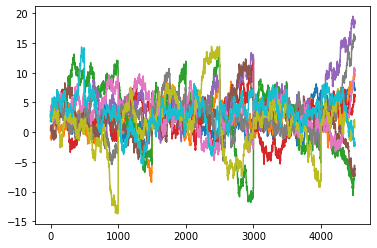

In [154]:
for i in range(nwalkers):
    plt.plot(mh_sampler.chain[i,:,0])

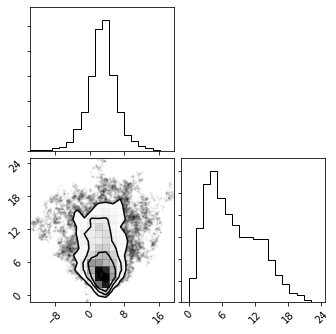

In [155]:
_ = corner.corner(mh_sampler.flatchain)

In [157]:
from IPython.display import display, Math
labels = ['mean', 'sd']
best_params = np.empty(ndim,)
for i in range(ndim):
    mcmc = np.percentile(mh_sampler.get_chain(thin=15, flat=True)[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    best_params[i] = mcmc[1]
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [179]:
firefly_move = emcee.moves.FireflyMove(
    datapoints=gaussian_data,
    pseudo_log_prob_per=pseudo_log_prob_per,
    bound_prob=bound_prob,
    proposal_function=proposal,
    nwalkers=nwalkers,
    ndim=ndim
)

firefly_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, moves=[firefly_move])
_ = firefly_sampler.run_mcmc(p0, 1000, progress='notebook')

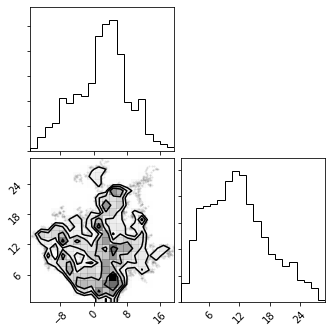

In [180]:
_ = corner.corner(firefly_sampler.flatchain)

In [237]:
from scipy.special import expit
theta = np.array([1, 2, 3])
X = np.random.randn(100, 3)
y = ((theta @ X.T > 0).astype(int) * 2 - 1)
dataset = np.vstack((X.T, y.reshape(1,100))).T

In [238]:
dataset[:,-1] @ dataset[:,:-1] @ theta

291.73291797579793

In [249]:
# first let's do normal MCMC 
def log_prob(param):
    if not all(np.isfinite(param)):
        return -np.inf
    logistic_factors = dataset[:,-1] @ dataset[:,:-1] @ param
    probs = -expit(logistic_factors)
    if np.isnan(probs):
        return -np.inf
    return probs

nwalkers = 2 * len(theta)
ndim = len(theta)

logistic_sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)
p0 = np.random.randn(nwalkers, ndim)
_ = logistic_sampler.run_mcmc(p0, 10000, progress='notebook')

/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in matmul
  """
/Users/adityasengupta/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in matmul
  """


ValueError: At least one parameter value was infinite

In [199]:
squig = 1.5
a = (-1 / (4 * squig)) * ((np.exp(squig) - 1)/(np.exp(squig) + 1))
b = 1/2
c = -a * squig ** 2 + (squig / 2) - np.log(np.exp(squig) + 1)
def pseudo_log_prob_per(datapoint, param):
    x = datapoint[-1] * param @ datapoint[:-1]
    return 1 - np.exp(a * x ** 2 + b * x + c) * (1 + np.exp(-x))



array([ 1, -1, -1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1,  1, -1,  1,
        1,  1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,
       -1, -1, -1, -1, -1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1,
       -1,  1, -1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,
       -1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,
       -1, -1,  1,  1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1,  1])